# Correlation between News Sentiment and Stock Movement
This notebook analyzes the relationship between news sentiment and stock price movements by aligning news and stock data, performing sentiment analysis, and computing correlations.

In [10]:
import pandas as pd
import numpy as np
from utils import load_data
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Load and Align Data
Load news and stock price data, and align them by date.

In [4]:
# Load news data
df_news = load_data('../data/raw_analyst_ratings.csv')
# Load stock data (example: TSLA, but can be parameterized)
df_stock = load_data('TSLA_historical_data.csv', base_dir='../data/yfinance_data')

# Convert date columns to datetime
df_news['date'] = pd.to_datetime(df_news['date'], errors='coerce')
df_news['date_only'] = df_news['date'].dt.date
df_stock['Date'] = pd.to_datetime(df_stock['Date'], errors='coerce')
df_stock['date_only'] = df_stock['Date'].dt.date

## 2. Sentiment Analysis on News Headlines
Use TextBlob to assign sentiment polarity to each news headline.

In [5]:
def get_sentiment(text):
    if pd.isna(text):
        return 0
    return TextBlob(text).sentiment.polarity

df_news['sentiment'] = df_news['headline'].apply(get_sentiment)

# Aggregate daily sentiment (mean sentiment per day)
daily_sentiment = df_news.groupby('date_only')['sentiment'].mean().reset_index()
daily_sentiment.columns = ['date_only', 'mean_sentiment']

## 3. Calculate Daily Stock Returns
Compute daily returns from closing prices.

In [6]:
df_stock = df_stock.sort_values('Date')
df_stock['daily_return'] = df_stock['Close'].pct_change()
daily_returns = df_stock[['date_only', 'daily_return']].dropna()

## 4. Merge Sentiment and Returns by Date

In [7]:
merged = pd.merge(daily_sentiment, daily_returns, on='date_only', how='inner')
merged = merged.dropna()
merged.head()

,date_only,mean_sentiment,daily_return
0,2011-04-27,0.000000,0.005570
1,2011-04-28,0.068182,0.021418
2,2011-04-29,0.166667,-0.002169
3,2011-05-02,-0.009259,-0.005435
4,2011-05-03,0.000000,-0.021130


## 5. Correlation Analysis
Test the correlation between daily news sentiment and stock returns.

In [8]:
correlation = merged['mean_sentiment'].corr(merged['daily_return'])
print(f"Correlation between daily news sentiment and stock returns: {correlation:.4f}")

Correlation between daily news sentiment and stock returns: 0.0277


## 6. Visualization
Visualize the relationship between sentiment and returns.

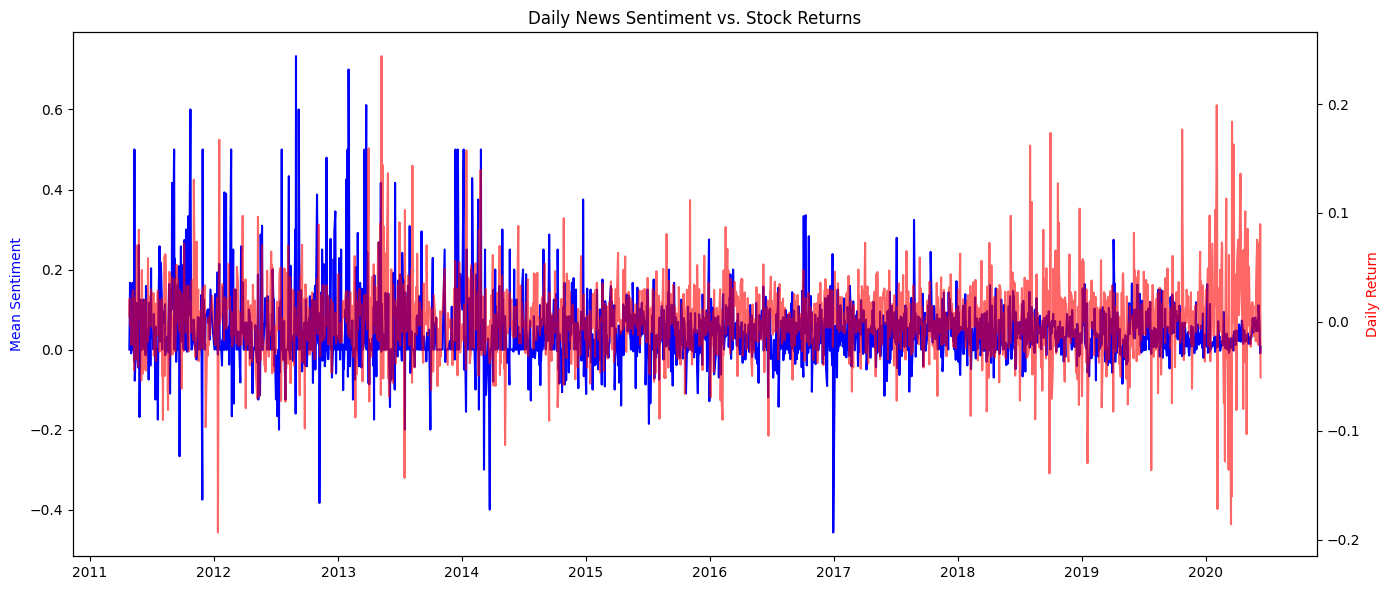

In [12]:
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(merged['date_only'], merged['mean_sentiment'], color='blue', label='Mean Sentiment')
ax1.set_ylabel('Mean Sentiment', color='blue')
ax2 = ax1.twinx()
ax2.plot(merged['date_only'], merged['daily_return'], color='red', label='Daily Return', alpha=0.6)
ax2.set_ylabel('Daily Return', color='red')
plt.title('Daily News Sentiment vs. Stock Returns')
fig.tight_layout()
plt.show()

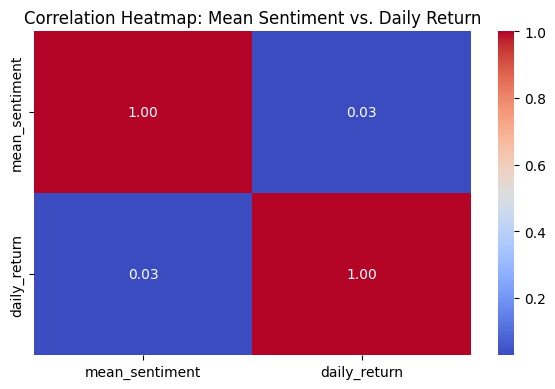

In [13]:
# Compute correlation matrix for all numeric columns
corr_matrix = merged[['mean_sentiment', 'daily_return']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: Mean Sentiment vs. Daily Return')
plt.tight_layout()
plt.show()